В этой домашке задания независимы

# Dropout (2 балла)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
input_size = 784
num_classes = 10
batch_size = 128
from sklearn.model_selection import train_test_split

train_dataset = dsets.MNIST(root='./MNIST/',
                                   train=True,
                                   transform=transforms.ToTensor(),
                                   download=True)
train_dataset, val_dataset = train_test_split(train_dataset,test_size=0.15)

test_dataset = dsets.MNIST(root='./MNIST/',
                                  train=False,
                                  transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 53.8MB/s]


Extracting ./MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 2.03MB/s]

Extracting ./MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 15.3MB/s]


Extracting ./MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 8.46MB/s]

Extracting ./MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw



In [3]:
def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)

    points = np.array(val_history)

    plt.scatter(points[:, 0], points[:, 1], marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')

    plt.legend(loc='best')
    plt.grid()

    plt.show()

def train(model, opt, n_epochs):
    train_log, train_acc_log = [], []
    val_log, val_acc_log = [], []


    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, opt, batchsize=batch_size)

        val_loss, val_acc = test(model)

        train_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        steps = train_dataset.train_labels.shape[0] / batch_size
        val_log.append((steps * (epoch + 1), np.mean(val_loss)))
        val_acc_log.append((steps * (epoch + 1), np.mean(val_acc)))

        clear_output()
        plot_history(train_log, val_log)
        plot_history(train_acc_log, val_acc_log, title='accuracy')

In [4]:
def test(model):
    loss_log, acc_log = [], []
    model.eval()
    for batch_num, (x_batch, y_batch) in enumerate(test_loader):
        data = Variable(x_batch)
        target = Variable(y_batch)

        output = model(data)
        loss = F.nll_loss(output, target).cpu()

        pred = torch.max(output, 1)[1].data.numpy()
        acc = np.mean(pred == y_batch)
        acc_log.append(acc)

        loss = loss.item()
        loss_log.append(loss)
    return loss_log, acc_log

In [5]:
def train_epoch(model, optimizer, batchsize=32):
    loss_log, acc_log = [], []
    model.train()
    for batch_num, (x_batch, y_batch) in enumerate(train_loader):
        data = Variable(x_batch)
        target = Variable(y_batch)

        optimizer.zero_grad()
        output = model(data)
        pred = torch.max(output, 1)[1].data.numpy()
        acc = np.mean(pred == y_batch)
        acc_log.append(acc)

        loss = F.nll_loss(output, target).cpu()
        loss.backward()
        optimizer.step()
        loss = loss.item()
        loss_log.append(loss)
    return loss_log, acc_log

In [6]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size()[0], -1)

model = nn.Sequential(
    Flatten(),
    nn.Linear(input_size, num_classes),
    nn.ReLU(),
    nn.LogSoftmax(dim=1)
    )

Меня не просили чинить функции. Я запустил вместо этой модели свою старую, которая выбивала скор 87 процентов на датасете fashion mnist. Она тоже не справляется с этим трейном, та же ошибка. Я, честно, не имею никакого желания переписывать или искать ошибки в этих функция

In [7]:
opt = torch.optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.CrossEntropyLoss()
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        opt.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        opt.step()

    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss/len(val_loader):.4f}, Validation Accuracy: {val_accuracy:.2f}%')

Epoch [1/30], Validation Loss: 0.5509, Validation Accuracy: 87.84%
Epoch [2/30], Validation Loss: 0.4164, Validation Accuracy: 89.80%
Epoch [3/30], Validation Loss: 0.3666, Validation Accuracy: 90.74%
Epoch [4/30], Validation Loss: 0.3401, Validation Accuracy: 91.09%
Epoch [5/30], Validation Loss: 0.3235, Validation Accuracy: 91.39%
Epoch [6/30], Validation Loss: 0.3120, Validation Accuracy: 91.64%
Epoch [7/30], Validation Loss: 0.3036, Validation Accuracy: 91.84%
Epoch [8/30], Validation Loss: 0.2972, Validation Accuracy: 91.97%
Epoch [9/30], Validation Loss: 0.2922, Validation Accuracy: 92.02%
Epoch [10/30], Validation Loss: 0.2881, Validation Accuracy: 92.12%
Epoch [11/30], Validation Loss: 0.2847, Validation Accuracy: 92.13%
Epoch [12/30], Validation Loss: 0.2819, Validation Accuracy: 92.18%
Epoch [13/30], Validation Loss: 0.2795, Validation Accuracy: 92.27%
Epoch [14/30], Validation Loss: 0.2774, Validation Accuracy: 92.31%
Epoch [15/30], Validation Loss: 0.2756, Validation Accura

ну это я делал в начале сентября, но грех не показать. Я написал сверточную сеть, которая выдала вполне неплохой скор. Ну и с этого задания я почерпнул урок о том, как тяжело копаться в чужом коде и искать ошибку, иногда легче переписать.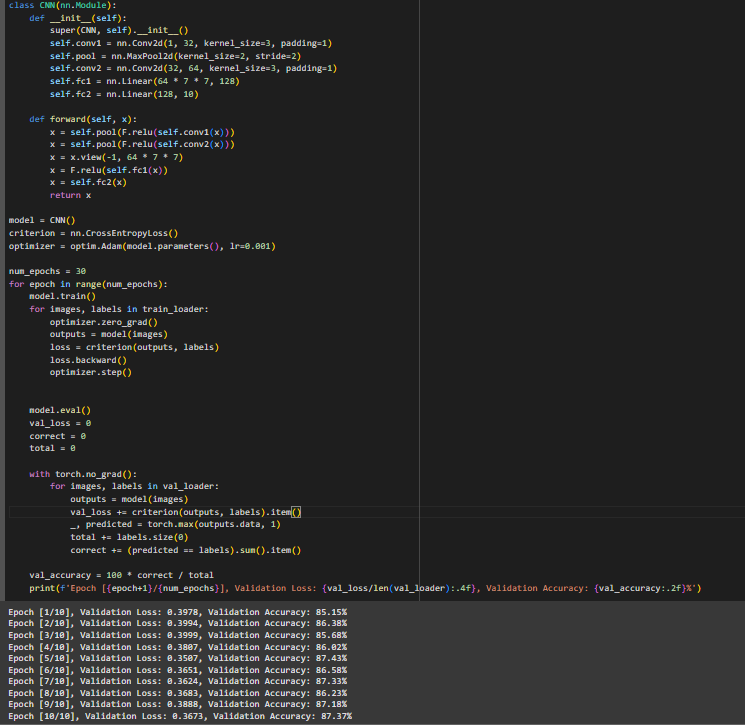

а тут я очень удивился. Я не зафиксировал random seed и у меня скор на валидации 92 процента выдало с картофельной однослойной моделькой
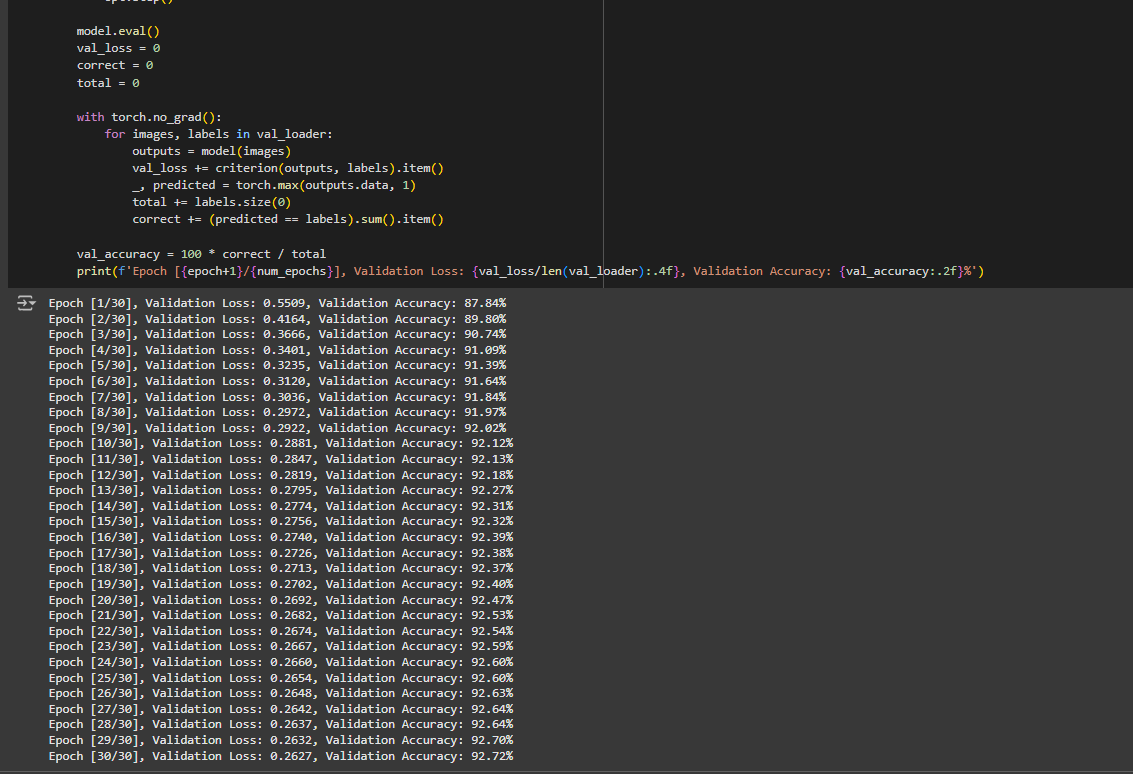

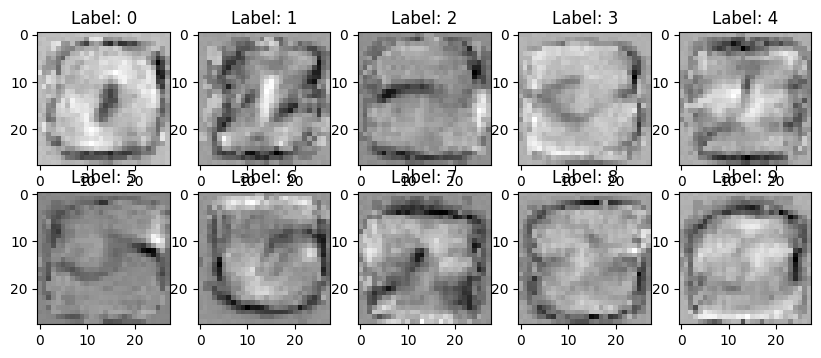

In [8]:
weights = list(model.parameters())[0].data.numpy()
plt.figure(figsize=[10, 10])
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.title("Label: %i" % i)
    plt.imshow(weights[i].reshape([28, 28]), cmap='gray');

In [9]:
class DropoutLayer(nn.Module):
    def __init__(self, p):
        super().__init__()
        self.p = p

    def forward(self, input):
        if self.training:
            dropout_factor = torch.bernoulli(torch.full(input.shape, 1 - self.p))
            return torch.mul(input, dropout_factor)
        else:
            return input

In [10]:
p = 0.7

modelDp = nn.Sequential(
    Flatten(),
    DropoutLayer(p),
    nn.Linear(input_size, num_classes),
    nn.ReLU(),
    nn.LogSoftmax(dim=1)
    )

In [11]:
opt = torch.optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.CrossEntropyLoss()
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        opt.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        opt.step()

    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss/len(val_loader):.4f}, Validation Accuracy: {val_accuracy:.2f}%')

Epoch [1/30], Validation Loss: 0.2621, Validation Accuracy: 92.70%
Epoch [2/30], Validation Loss: 0.2617, Validation Accuracy: 92.68%
Epoch [3/30], Validation Loss: 0.2613, Validation Accuracy: 92.68%
Epoch [4/30], Validation Loss: 0.2609, Validation Accuracy: 92.70%
Epoch [5/30], Validation Loss: 0.2606, Validation Accuracy: 92.69%
Epoch [6/30], Validation Loss: 0.2603, Validation Accuracy: 92.67%
Epoch [7/30], Validation Loss: 0.2600, Validation Accuracy: 92.64%
Epoch [8/30], Validation Loss: 0.2597, Validation Accuracy: 92.62%
Epoch [9/30], Validation Loss: 0.2594, Validation Accuracy: 92.67%
Epoch [10/30], Validation Loss: 0.2592, Validation Accuracy: 92.69%
Epoch [11/30], Validation Loss: 0.2589, Validation Accuracy: 92.67%
Epoch [12/30], Validation Loss: 0.2587, Validation Accuracy: 92.70%
Epoch [13/30], Validation Loss: 0.2585, Validation Accuracy: 92.70%
Epoch [14/30], Validation Loss: 0.2583, Validation Accuracy: 92.73%
Epoch [15/30], Validation Loss: 0.2581, Validation Accura

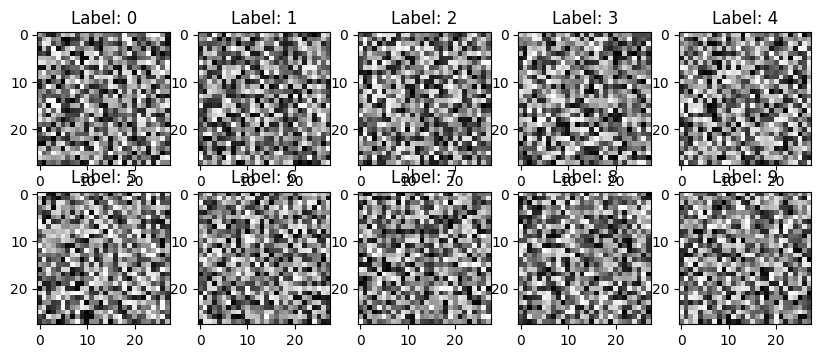

In [12]:
weights = list(modelDp.parameters())[0].data.numpy()
plt.figure(figsize=[10, 10])
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.title("Label: %i" % i)
    plt.imshow(weights[i].reshape([28, 28]), cmap='gray');

ну тут всегда должна быть каша, особенно на таких маленьких моделях. Я вот дошёл до трансформеров и уже на них классифицировал текст. У них визуализация голов внимания красивая и можно реально увидеть, на что обращает внимание нейронка ( хоть и не всегда). Надеюсь, вы мне простите отсутствие графиков при обучении моделей. Я никак не смог воспользоваться нормально данным для ноутбука кодом

# Metric Learning (3 балла)

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data.sampler import Sampler, BatchSampler
from torch.nn.modules.loss import MSELoss

Contrastive Loss - одна из самых популярных функций потерь для metric learning. Contrastive Loss получает на вход пару векторов $x_i$ и $x_j$ и метку $y_{ij}$, причем $y_{ij} = 0$, если объекты "похожи" (принадлежат одному классу), и $y_{ij} = 1$, если объекты "различны" (принадлежат различным классам). Формально определим Contrastive Loss следующим образом:

$$
L(x_i, x_j, y_{ij}) = (1 - y_{ij})\|x_i - x_j\|^2 + y_{ij}max(0, m - \|x_i - x_j\|^2)
$$

где $m$ - гиперпараметр (его можно взять равным единице).

Вместо того, чтобы формировать обучающее множество из всевозможных пар, можно поступить проще: будем пропускать батч из $N$ обучаюших изображений через сеть (тем самым получая соответствующие векторы $x$), а значение лосса вычислять как среднее значение функции $L$ на всех парах в этом батче. Тогда в обучении на каждом батче участвует $\frac{N(N-1)}{2}$ пар, что существенно ускоряет сходимость на практике. Реализуйте предложенный вариант Contrastive Loss.

In [14]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = nn.functional.pairwise_distance(output1, output2)
        loss_positive = label * torch.pow(euclidean_distance, 2)
        loss_negative = (1 - label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
        loss = torch.mean(loss_positive + loss_negative)
        return loss

В задачах metric learning, как правило, необходимо, чтобы количества "положительных" и "отрицательных" пар в обучении отличалось несильно. Поэтому в случае большого количества классов случайное формирование батчей неэффективно - в таком случае количество "положительных" пар очень мало. Поэтому будем формировать обучающие батчи размера $N$ следующим образом: будем брать $\frac{N}{2}$ элементов из некоторого класса (они между собой будут формировать "положительные пары"), а оставшиеся $\frac{N}{2}$ элементов будем брать случайно. Таким образом мы гарантируем, что в каждом обучающем батче будет достаточно "положительных" пар.

In [15]:
from collections import defaultdict

В этом задании будем работать с небольшими изображениями одежды из датасета Fashion-MNIST.

In [16]:
class ContrastiveSampler(BatchSampler):
    def __init__(self, batch_size, num_classes, labels):
        self.num_classes = num_classes
        self.imgs_per_class = labels.size()[0] // num_classes
        class2idx = defaultdict(list)
        for i, y in enumerate(labels):
            class2idx[i].append(y)
        self.batch_size = batch_size
        self.class2idx = class2idx
        self.total_samples = len(labels)

    def __iter__(self):
        num_yielded = 0
        while num_yielded < (self.num_classes * self.imgs_per_class):
            batch = []
            base = np.random.randint(0, self.num_classes)
            pos = np.random.choice(self.class2idx[base], size=self.batch_size // 2).tolist()
            neg = np.random.randint(self.total_samples, size=self.batch_size // 2).tolist()
            batch += pos + neg
            num_yielded += self.batch_size
            yield batch

In [21]:
!pip install --upgrade torchvision

In [26]:
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader, random_split

In [31]:
input_size = 784
num_classes = 10
batch_size = 256

contrastive_loss = ContrastiveLoss()

train_dataset = dsets.FashionMNIST(root='.',
                                   train=True,
                                   transform=transforms.ToTensor(),
                                   download=True)
test_dataset = dsets.FashionMNIST(root='.',
                                  train=False,
                                  transform=transforms.ToTensor())

# Определяем размеры для обучающего и валидационного наборов
train_size = int(0.85 * len(train_dataset))
val_size = len(train_dataset) - train_size

# Разбиваем на обучающий и валидационный наборы
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Получаем метки
train_labels = torch.tensor([train_dataset[i][1] for i in range(len(train_dataset))])
val_labels = torch.tensor([val_dataset[i][1] for i in range(len(val_dataset))])
test_labels = test_dataset.targets

Ну тут уже поздно, но ко мне пришло осознание, что у нас тест имеет лейблы и можно тест использовать, как валидацию, но уже поздно, но я это даже заметил

Реализуйте сеть несложной архитектуры, содержащую три сверточных слоя из 20 фильтров с макс-пулингом, а также два полносвязных слоя из 128 нейронов. Выход последнего слоя будет подаваться на вход Contrastive Loss.

In [33]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_sampler=ContrastiveSampler(batch_size=batch_size,
                                           num_classes=num_classes, labels=train_labels),
                                           shuffle=False)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_sampler=ContrastiveSampler(batch_size=batch_size,
                                           num_classes=num_classes, labels=val_labels),
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_sampler=ContrastiveSampler(batch_size=batch_size,
                                          num_classes=num_classes, labels=test_labels),
                                          shuffle=False)

Этот ноутбук с ошибками!!!!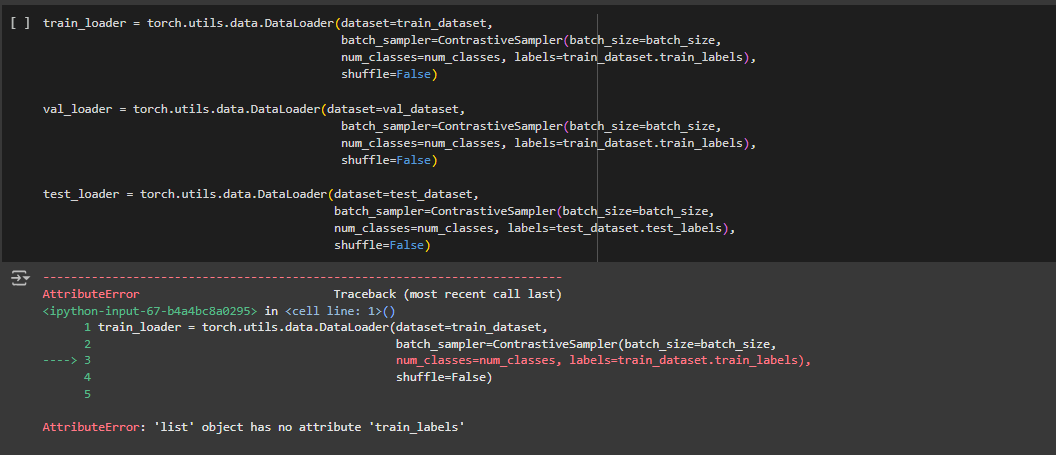

у меня от такого сдали нервы. Contractivenetwork берёт два изображения. В препроциссинг должно было быть включено дробление на пары. Ну ладно. Возможно тут делалось с обучением на двух батчах (так и есть). Чат гпт мне говорит, что это хуже двух изображений, ладно. НО ОНО ВООБЩЕ НЕ РАБОТАЕТ. ФУНКЦИЯ ОБУЧЕНИЯ НЕ МОЖЕТ РАБОТАТЬ БЕЗ ОШИБКИ. ЕЙ ТО ЛЕЙБЛОВ НЕ ХВАТАЕТ, ТО НЕТ ВТОРОГО ИЗОБРАЖЕНИЯ ДЛЯ ВСТАВКИ В СЕТЬ, ТО РАЗМЕР БАТЧЕЙ НЕ СХОДИТСЯ. У МЕНЯ НЕТ СЛОВ.

In [62]:
from torch.utils.data import Dataset, DataLoader

In [63]:
class PairDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.labels = [label for _, label in dataset]
        self.label_to_indices = {label: [] for label in set(self.labels)}

        for index, label in enumerate(self.labels):
            self.label_to_indices[label].append(index)

    def __len__(self):
        return len(self.dataset)  # Можно вернуть длинну вашего источника данных

    def __getitem__(self, index):
        # Получаем положительный пример
        img1, label1 = self.dataset[index]

        # Найдем положительный пример (аналогичный класс)
        pos_index = random.choice(self.label_to_indices[label1])
        img2, label2 = self.dataset[pos_index]  # Положительный пример

        # Для отрицательного примера нужно выбрать класс, не совпадающий с текущим
        negative_label = random.choice(list(set(self.labels) - {label1}))
        neg_index = random.choice(self.label_to_indices[negative_label])
        neg_img, neg_label = self.dataset[neg_index]  # Отрицательный пример

        return img1, img2, neg_img, label1, label2, neg_label  # Возвращаем пару изображений и их метки

# Основная часть со всеми подготовками
transform = transforms.ToTensor()
train_dataset = datasets.FashionMNIST(root='.', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='.', train=False, transform=transform, download=True)
pair_train_dataset = PairDataset(train_dataset)
pair_train_dataset = PairDataset(test_dataset)
train_size = int(0.85 * len(train_dataset))
val_size = len(train_dataset) - train_size

# Разбиваем на обучающий и валидационный наборы
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Получаем метки
train_labels = torch.tensor([train_dataset[i][1] for i in range(len(train_dataset))])
val_labels = torch.tensor([val_dataset[i][1] for i in range(len(val_dataset))])
test_labels = test_dataset.targets

In [64]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_sampler=ContrastiveSampler(batch_size=batch_size,
                                           num_classes=num_classes, labels=train_labels),
                                           shuffle=False)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_sampler=ContrastiveSampler(batch_size=batch_size,
                                           num_classes=num_classes, labels=val_labels),
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_sampler=ContrastiveSampler(batch_size=batch_size,
                                          num_classes=num_classes, labels=test_labels),
                                          shuffle=False)

In [74]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

import torch
import torch.nn as nn
import torch.nn.functional as F

class ContrastiveNetwork(nn.Module):
    def __init__(self):
        super(ContrastiveNetwork, self).__init__()
        # Конволюционные слои
        self.cnn1 = nn.Conv2d(1, 20, kernel_size=5, stride=1, padding=2)  # Output: (20, 28, 28)
        self.cnn2 = nn.Conv2d(20, 50, kernel_size=5, stride=1, padding=2)  # Output: (50, 28, 28)
        self.cnn3 = nn.Conv2d(50, 50, kernel_size=5, stride=1, padding=2)  # Output: (50, 28, 28)

        # Max pooling слои
        self.pool = nn.MaxPool2d(2, 2)  # Output: (x/2, y/2)

        # Полносвязные слои
        self.fc1 = nn.Linear(50 * 3 * 3, 256)  # Input size нужно будет пересчитать
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 10)  # Классы Fashion MNIST: 10 классов

    def forward(self, x,y):
        x = F.relu(self.cnn1(x))
        x = self.pool(x)
        x = F.relu(self.cnn2(x))
        x = self.pool(x)
        x = F.relu(self.cnn3(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        y = F.relu(self.cnn1(y))
        y = self.pool(y)
        y = F.relu(self.cnn2(y))
        y = self.pool(y)
        y = F.relu(self.cnn3(y))
        y = self.pool(y)
        y = y.view(y.size(0), -1)
        y = F.relu(self.fc1(y))
        y = F.relu(self.fc2(y))
        y = self.fc3(y)
        return x,y


In [75]:
model = ContrastiveNetwork()

Обучите сеть с параметрами, указанными ниже.

In [76]:
opt = torch.optim.Adam(model.parameters(), lr=0.0005)
criterion = ContrastiveLoss()
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        img1= images[0]
        img2= images[1]
        opt.zero_grad()
        output1, output2 = model(img1, img2)
        loss = criterion(output1, output2, labels)
        loss.backward()
        opt.step()

    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for (img1, img2), labels in val_loader:
            output1, output2 = model(img1, img2)
            val_loss += criterion(output1, output2, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss/len(val_loader):.4f}, Validation Accuracy: {val_accuracy:.2f}%')

RuntimeError: mat1 and mat2 shapes cannot be multiplied (50x9 and 450x256)

Извлеките векторные описания тестовых изображений (a.k.a эмбеддинги). У вас должно получиться 10000 128-мерных векторов.

In [ ]:
data = test_dataset.test_data
embeddings = model(Variable(data.view(-1, 1, 28, 28)).float())

Код ниже демонстрирует поисковую выдачу для трех изображений-запросов. Выдача формируется на основе близости эмбеддингов.

In [ ]:
queryCount = 3
queries = embeddings[:queryCount,:].data.numpy()
database = embeddings[queryCount:,:].data.numpy()
plt.figure(figsize=[15, 4.5])
for i in range(queryCount):
    results = np.argsort(np.sum((database-queries[i,:])**2, axis=1))[:10]
    plt.subplot(queryCount, 11, i * 11 + 1)
    plt.title("Query: %i" % i)
    plt.imshow(test_dataset.test_data[i].numpy().reshape([28, 28]), cmap='gray')
    for k in range(10):
        plt.subplot(queryCount, 11, i * 11 + k + 2)
        plt.imshow(test_dataset.test_data[results[k]+queryCount].numpy().reshape([28, 28]), cmap='gray')

# Super-resolution (3 балла)

В этой части вам предстоит реализовать простейшую архитектуру для решения задачи image super-resolution.

In [77]:
input_size = 784
num_classes = 10
batch_size = 256

train_dataset = dsets.MNIST(root='./MNIST/',
                            train=True,
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = dsets.MNIST(root='./MNIST/',
                           train=False,
                           transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

Мы будем увеличивать изображения размера (14,14) в два раза по каждому измерению. Как правило, перед подачей на вход нейросети изображение низкого разрешения увеличивают до нужного размера билинейной интерполяцией, а нейросеть улучшает результат интерпляции, не меняя пространственные размеры изображения.

Реализуйте нейросеть из трех сверточных слоев, которая будет получать на вход черно-белое изображение и выдавать на выход изображение такого же размера. Нейросеть должна предсказывать добавку, которую необходимо прибавить к полученному на вход изображению низкого качества.

In [78]:
class SuperResolutionNetwork(nn.Module):
    def __init__(self):
        super(SuperResolutionNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),  # Первый свёрточный слой
            nn.ReLU(inplace=True),                        # Функция активации ReLU
            nn.Conv2d(64, 64, kernel_size=3, padding=1), # Второй свёрточный слой
            nn.ReLU(inplace=True),                        # Функция активации ReLU
            nn.Conv2d(64, 1, kernel_size=3, padding=1),  # Третий свёрточный слой
        )

    def forward(self, x):
        output = self.cnn1(x)  # Проходим входные данные через свёрточные слои
        return output + x

In [79]:
model = SuperResolutionNetwork()

In [80]:
def low_res_and_high_res(images_batch):
    result = images_batch.clone()
    low_res_transform = transforms.Resize((14,14))
    high_res_transform = transforms.Resize((28,28))
    toTensorTransform = transforms.ToTensor()
    toImageTransform = transforms.ToPILImage()
    for i in range(images_batch.size()[0]):
        result[i] = toTensorTransform(high_res_transform(low_res_transform(toImageTransform(images_batch[i]))))
    return result

def train_epoch(model, optimizer, batchsize=32):
    loss_log = []
    model.train()
    for batch_num, (x_batch, y_batch) in enumerate(train_loader):
        x_batch = x_batch.float() / 255
        data = Variable(low_res_and_high_res(x_batch))
        target = Variable(x_batch)
        optimizer.zero_grad()
        output = model(data)
        loss = F.mse_loss(output, target)
        loss.backward()
        optimizer.step()
        loss = loss.data.item()
        loss_log.append(loss)
    return loss_log

def test(model):
    loss_log = []
    model.eval()
    for batch_num, (x_batch, y_batch) in enumerate(test_loader):
        x_batch = x_batch.float() / 255
        data = Variable(low_res_and_high_res(x_batch))
        target = Variable(x_batch)
        output = model(data)
        loss = F.mse_loss(output, target)
        loss = loss.data.item()
        loss_log.append(loss)
    return loss_log

def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    points = np.array(val_history)
    plt.scatter(points[:, 0], points[:, 1], marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

def train(model, opt, n_epochs):
    train_log = []
    val_log = []
    for epoch in range(n_epochs):
        train_loss = train_epoch(model, opt, batchsize=batch_size)
        val_loss = test(model)
        train_log.extend(train_loss)
        steps = train_dataset.train_labels.shape[0] / batch_size
        val_log.append((steps * (epoch + 1), np.mean(val_loss)))
        clear_output()
        plot_history(train_log, val_log)

Оптимизируйте сеть с параметрами, указанными ниже.

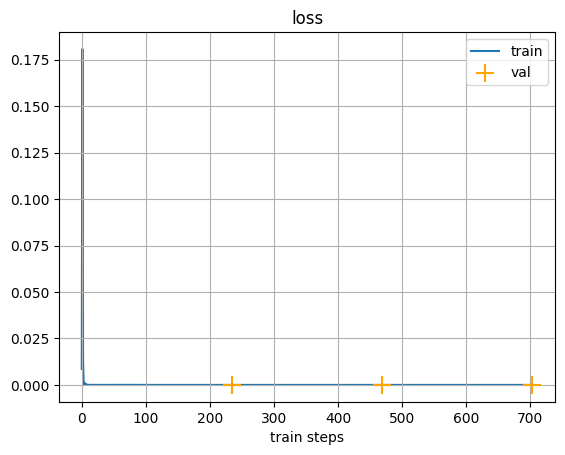

In [81]:
opt = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=0.05)
train(model, opt, 3)

In [82]:
test_images = test_dataset.test_data.float() / 255
result_cnn = model(Variable(low_res_and_high_res(test_images.view(-1,1,28,28))))

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:81: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


Код ниже визуализирует исходные изображения (28,28) и реконструкции, полученные с помощью нейросети.
Не удивляйтесь, есть качество реконструкций покажется низким, MSE-loss, не является оптимальным для задачи super-resolution (гораздо лучше работают GANы, расскажу позже).

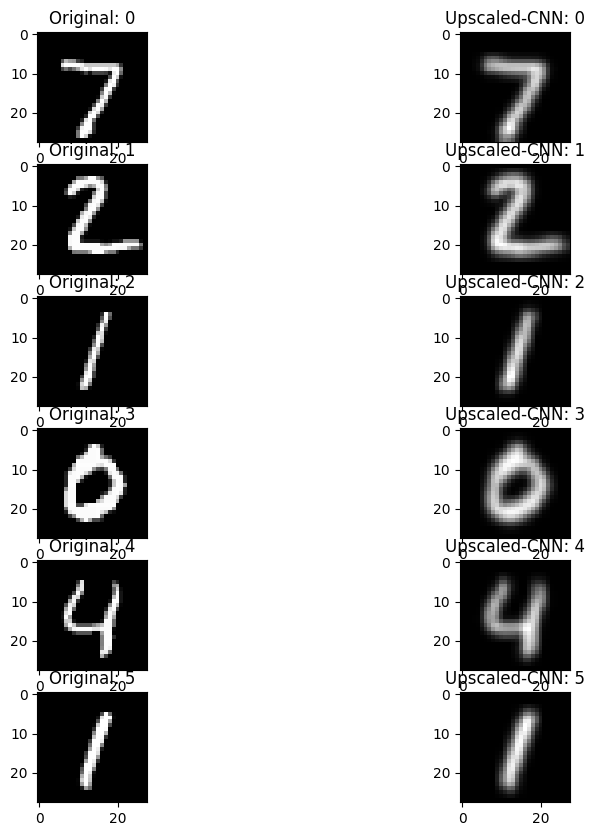

In [83]:
examplesCount = 6
plt.figure(figsize=[10, 10])
for i in range(examplesCount):
    plt.subplot(examplesCount, 2, i * 2 + 1)
    plt.title("Original: %i" % i)
    plt.imshow(test_dataset.test_data[i].numpy().reshape([28, 28]), cmap='gray')
    plt.subplot(examplesCount, 2, i * 2 + 2)
    plt.title("Upscaled-CNN: %i" % i)
    plt.imshow(result_cnn[i].data.numpy().reshape([28, 28]), cmap='gray')

У меня никогда не было такого сильного выгорания, как от этой домашки. ПОЧЕМУ РАБОТАЕТ ТОЛЬКО ТРЕТИЙ КУСОЧЕК КОДА? ПОЧЕМУ Я ДВА ДНЯ ПЫТАЮСЬ ЧИНИТЬ НЕРАБОТАЮЩИЕ ПЕРВЫЕ ДВА КУСОЧКА И У МЕНЯ НЕ ПОЛУЧАЕТСЯ, А ТУТ НАПИСАЛ ТРИ СТРОЧКИ И ГОТОВО? ТУТ ЖЕ ЗАДАНИЕ БЫЛО ВСТАВИТЬ 4-5 ФРАГМЕНТА И ВСЁ ДОЛЖНО РАБОТАТЬ, НО ГДЕ-ТО МНЕ ПРИШЛОСЬ ПРЕПРОЦЕССИНГ ДЕЛАТЬ ЗАНОВО, ПОТОМУ ЧТО ДАННЫЙ КОД ВЫДАВАЛ ОШИБКУ. КАК ПОФИКСИТЬ НЕСООТВЕТСТВИЕ РАЗМЕРОВ МАТРИЦ ВО ВТОРОМ Я НЕ НАШЁЛ... Я правда пытался. Вы не представляете как. Я вставлял флэттен где мог, я вставил свою функцию для обучения, расширил её через боль, кровь и второй новый препроцессинг для кортежей изображений, потому что это "отличная" метрика хочет два изображения. У меня батч с кортежами... Два изображения... Я не понимаю, как иначе нам брать изображения из батча... Мне предлагают каждое с каждым сравнить вроде как, а вот это я подавно не знаю, ужасная метрика, я не буду ей пользоваться. Извините за черезмерный капс. Это всё написано на впечатлениях от работы, которая должна занять час, а не два дня...

Забавные моменты, качество картофельной модельки взлетело выше средней нейронки. Лосс третьего кусочка после написание плюс минус 4 строчек кода улетел в 0, а время обучения улетело не пойми куда. Я выгорел до тла, пока делал эту работу. Я пользовался чатом GPT, даже он мне не помог. Ещё один смшеной момент, в СУНЦе настолько отсойный интернет, что у меня моделька обучается час и я понятия не имею, в чем проблема